In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import itertools

Importing plotly failed. Interactive plots will not work.


In [ ]:
# marketing campains
# and moving inventory from one channel to another is not considered
# discounts are not considered

In [2]:
soh = pd.read_csv('../data/sales tables/soh.csv')
soh['date'] = pd.to_datetime(soh[['year', 'month']].assign(day=1)).dt.strftime('%Y-%m-%d')

# grn = pd.read_csv('../data/sales tables/grn.csv')
# grn['date'] = pd.to_datetime(grn[['year', 'month']].assign(day=1)).dt.strftime('%Y-%m-%d')
# grn[['date', 'qty']].groupby('date').sum().plot()

sales = pd.read_csv('../data/sales tables/sales_monthly.csv')
sales['date'] = pd.to_datetime(sales[['year', 'month']].assign(day=1)).dt.strftime('%Y-%m-%d')
# sales[['date', 'qty']].groupby('date').sum().plot()

returns = pd.read_csv('../data/sales tables/returns.csv')
returns['date'] = pd.to_datetime(returns[['year', 'month']].assign(day=1)).dt.strftime('%Y-%m-%d')
# returns[['date', 'qty']].groupby('date').sum().plot()

net_sales = sales[['date', 'qty']].groupby('date').sum() - returns[['date', 'qty']].groupby('date').sum()

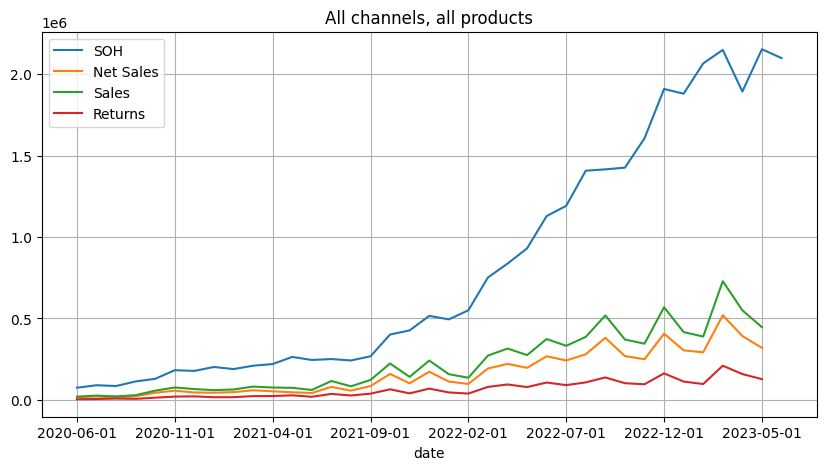

In [4]:
ax = soh[['date', 'qty']].groupby('date').sum().rename(columns={'qty': 'SOH'}).plot(figsize=(10, 5))
net_sales.rename(columns={'qty': 'Net Sales'}).plot(ax=ax)
sales[['date', 'qty']].groupby('date').sum().rename(columns={'qty': 'Sales'}).plot(ax=ax)
returns[['date', 'qty']].groupby('date').sum().rename(columns={'qty': 'Returns'}).plot(ax=ax)
plt.title('All channels, all products')
plt.grid(True)

In [47]:
master = pd.read_csv('../data/prod-2023-10-16-11-22-06.csv')
# master.head()

soh['product'] = soh['ean'].map(master.set_index('ean')['product'])
# grn['product'] = grn['ean'].map(master.set_index('ean')['product'])
sales['product'] = sales['ean'].map(master.set_index('ean')['product'])
returns['product'] = returns['ean'].map(master.set_index('ean')['product'])
# grn.head()

/var/folders/gb/1cwn6rds3vv7p30s87jjmp200000gn/T/ipykernel_1422/90103124.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  master = pd.read_csv('../data/prod-2023-10-16-11-22-06.csv')


In [48]:
ean_product_map = pd.read_csv('../data/rajbrain/sud/ean-product-map.csv')
# ean_product_map.head()

mask = soh['product'].isnull()
soh.loc[mask, 'product'] = soh.loc[mask, 'ean'].map(ean_product_map.set_index('EAN')['Product'])
# soh[soh['product'].isnull()].sort_values('qty', ascending=False)

mask = sales['product'].isnull()
sales.loc[mask, 'product'] = sales.loc[mask, 'ean'].map(ean_product_map.set_index('EAN')['Product'])
# sales[sales['product'].isnull()].sort_values('qty', ascending=False)

mask = returns['product'].isnull()
returns.loc[mask, 'product'] = returns.loc[mask, 'ean'].map(ean_product_map.set_index('EAN')['Product'])
# returns[returns['product'].isnull()].sort_values('qty', ascending=False)

In [49]:
soh.replace('Sweat Shirt','Sweatshirt', inplace=True)
soh.replace('Jackets (PU)','Jacket', inplace=True)
soh.replace('Jackets','Jacket', inplace=True)
sales.replace('Sweat Shirt','Sweatshirt', inplace=True)
sales.replace('Jackets (PU)','Jacket', inplace=True)
sales.replace('Jackets','Jacket', inplace=True)
returns.replace('Sweat Shirt','Sweatshirt', inplace=True)
returns.replace('Jackets (PU)','Jacket', inplace=True)
returns.replace('Jackets','Jacket', inplace=True)

In [50]:
soh_grouped = soh[['qty','date', 'product', 'channel_id']].groupby(['date', 'channel_id', 'product']).sum().reset_index()
sales_grouped = sales[['qty','date', 'product', 'channel_id']].groupby(['date', 'channel_id', 'product']).sum().reset_index()
returns_grouped = returns[['qty','date', 'product', 'channel_id']].groupby(['date', 'channel_id', 'product']).sum().reset_index()

In [51]:
all_products = set(soh_grouped['product'].unique()).union(set(sales_grouped['product'].unique())).union(set(returns_grouped['product'].unique()))
all_channels = list(range(1, 7))
min_date = min(soh_grouped.date.min(), sales_grouped.date.min(),returns_grouped.date.min())
max_date = max(soh_grouped.date.max(), sales_grouped.date.max(),returns_grouped.date.max())
all_dates = pd.date_range(start=min_date, end=max_date, freq='MS').strftime('%Y-%m-%d')

index = pd.MultiIndex.from_tuples(list(itertools.product(all_channels, all_products, all_dates)), names=['channel_id', 'product', 'date'])
master_group = pd.DataFrame(index=index)

master_group = master_group.merge(soh_grouped, on=['channel_id', 'product', 'date'], how='left').rename(columns={'qty': 'qty_soh'}).fillna(0)
master_group = master_group.merge(sales_grouped, on=['channel_id', 'product', 'date'], how='left').rename(columns={'qty': 'qty_sales'}).fillna(0)
master_group = master_group.merge(returns_grouped, on=['channel_id', 'product', 'date'], how='left').rename(columns={'qty': 'qty_returns'}).fillna(0)
master_group['qty_net'] = master_group['qty_sales'] - master_group['qty_returns']
master_group

,channel_id,product,date,qty_soh,qty_sales,qty_returns,qty_net
0,1,Waistcoat,2020-06-01,572.0,35.0,0.0,35.0
1,1,Waistcoat,2020-07-01,608.0,63.0,0.0,63.0
2,1,Waistcoat,2020-08-01,708.0,124.0,0.0,124.0
3,1,Waistcoat,2020-09-01,1058.0,169.0,0.0,169.0
4,1,Waistcoat,2020-10-01,1001.0,341.0,0.0,341.0
...,...,...,...,...,...,...,...
7099,6,Denim Shorts,2023-02-01,0.0,0.0,0.0,0.0
7100,6,Denim Shorts,2023-03-01,0.0,0.0,0.0,0.0
7101,6,Denim Shorts,2023-04-01,0.0,0.0,0.0,0.0
7102,6,Denim Shorts,2023-05-01,0.0,0.0,0.0,0.0


In [52]:
# channel_id = 3

# for product in master_group['product'].unique():
#     ax = master_group[(master_group['channel_id']==channel_id)&(master_group['product']==product)].plot(x='date', y='qty_net', figsize=(10, 5))
#     master_group[(master_group['channel_id']==channel_id)&(master_group['product']==product)].plot(x='date', y='qty_soh', figsize=(10, 5), ax=ax)
#     plt.title('Channel Id: ' + str(channel_id) + ', Product: ' + product)
#     plt.grid(True)


# zz = master_group.groupby(['date', 'product']).sum().reset_index()
# for product in zz['product'].unique():
#     ax = zz[zz['product']==product].plot(x='date', y='qty_net', figsize=(10, 5))
#     zz[zz['product']==product].plot(x='date', y='qty_soh', figsize=(10, 5), ax=ax)
#     plt.title('All Channels, Product: ' + product)
#     plt.grid(True)

In [53]:
df = master_group.rename(columns={'date': 'ds', 'qty_net': 'y'})
df.drop(['qty_sales', 'qty_returns'], axis=1, inplace=True)

product_encodings = pd.get_dummies(df['product'], prefix='product')
df = pd.concat([df, product_encodings], axis=1)

channel_id_encodings = pd.get_dummies(df['channel_id'], prefix='channel_id')
df = pd.concat([df, channel_id_encodings], axis=1)

df.drop(['product', 'channel_id'], axis=1, inplace=True)
df

,ds,qty_soh,y,product_Blazer,product_Boxers,product_Cargo,product_Chinos,product_Co-ordinates,product_Denim Jogger,product_Denim Shorts,...,product_Trousers,product_Waistcoat,product_WindCheater,product_Woven Shorts,channel_id_1,channel_id_2,channel_id_3,channel_id_4,channel_id_5,channel_id_6
0,2020-06-01,572.0,35.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,2020-07-01,608.0,63.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,2020-08-01,708.0,124.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,2020-09-01,1058.0,169.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,2020-10-01,1001.0,341.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7099,2023-02-01,0.0,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7100,2023-03-01,0.0,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7101,2023-04-01,0.0,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7102,2023-05-01,0.0,0.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [54]:
m = Prophet()
m.add_regressor('qty_soh')
for col in set(df.columns) - {'ds', 'qty_soh', 'y'}:
    m.add_regressor(col)
m.fit(df)

11:41:22 - cmdstanpy - INFO - Chain [1] start processing
11:41:22 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
# assuming you maintain the same soh as the last month for the next 3 months
predict_months = 3
channel_id = 3
product = 'Shirt'

future = pd.DataFrame()
future['ds'] = pd.date_range(start=df.ds.max(), periods=predict_months+1, freq='MS')[1:]
for col in master_group['product'].unique():
    future[f'product_{col}'] = 0
for col in master_group['channel_id'].unique():
    future[f'channel_id_{col}'] = 0
future[f'product_{product}'] = 1
future[f'channel_id_{channel_id}'] = 1
future['qty_soh'] = master_group[(master_group['product'] == product) & (master_group['channel_id'] == channel_id)]['qty_soh'].iloc[-1]
forecast = m.predict(future)

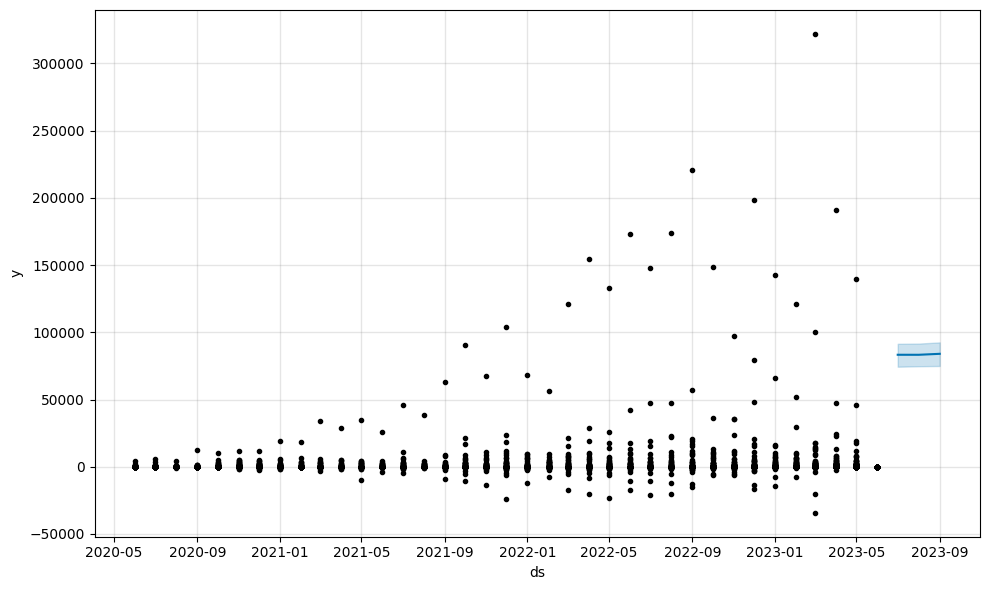

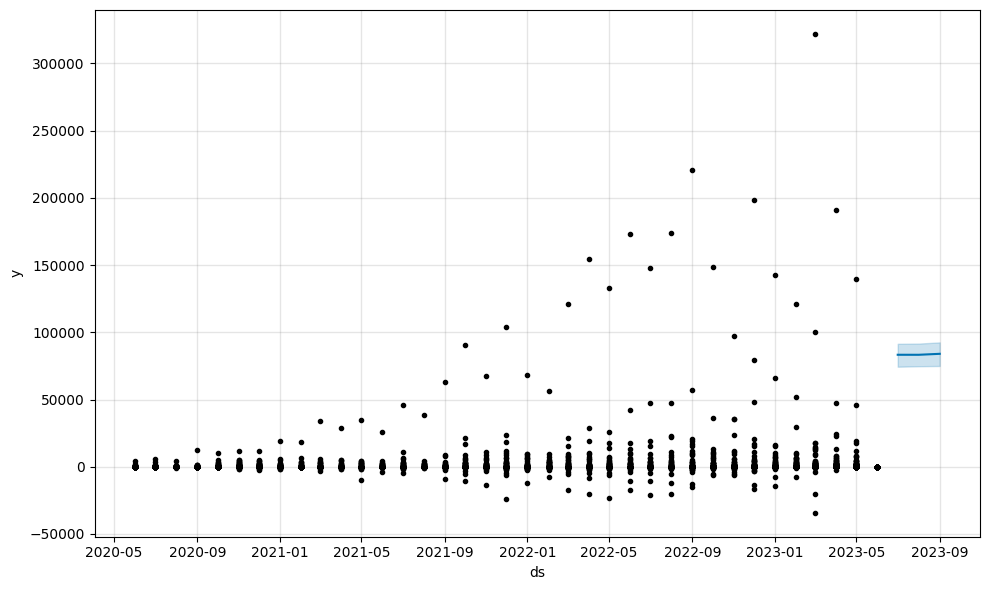

In [56]:
m.plot(forecast)
# m.plot_components(forecast)

In [57]:
df = master_group.groupby(['date', 'product']).sum().reset_index().rename(columns={'date': 'ds', 'qty_net': 'y'})
df.drop(['qty_sales', 'qty_returns'], axis=1, inplace=True)

product_encodings = pd.get_dummies(df['product'], prefix='product')
df = pd.concat([df, product_encodings], axis=1)

# channel_id_encodings = pd.get_dummies(df['channel_id'], prefix='channel_id')
# df = pd.concat([df, channel_id_encodings], axis=1)

df.drop(['product', 'channel_id'], axis=1, inplace=True)
df

,ds,qty_soh,y,product_Blazer,product_Boxers,product_Cargo,product_Chinos,product_Co-ordinates,product_Denim Jogger,product_Denim Shorts,...,product_Shorts,product_Shrug,product_Sweatshirt,product_T-Shirt,product_Tops,product_Tracksuit,product_Trousers,product_Waistcoat,product_WindCheater,product_Woven Shorts
0,2020-06-01,1529.0,78.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-06-01,547.0,353.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-06-01,1845.0,1263.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-06-01,3731.0,613.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-06-01,2944.0,294.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2023-06-01,3776.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1180,2023-06-01,16019.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1181,2023-06-01,1245.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1182,2023-06-01,7714.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [58]:
m = Prophet()
m.add_regressor('qty_soh')
for col in set(df.columns) - {'ds', 'qty_soh', 'y'}:
    m.add_regressor(col)
m.fit(df)

11:41:23 - cmdstanpy - INFO - Chain [1] start processing
11:41:24 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
# assuming you maintain the same soh as the last month for the next 3 months
predict_months = 3
product = 'Shirt'

future = pd.DataFrame()
future['ds'] = pd.date_range(start=df.ds.max(), periods=predict_months+1, freq='MS')[1:]
for col in master_group['product'].unique():
    future[f'product_{col}'] = 0
future[f'product_{product}'] = 1
future['qty_soh'] = master_group[master_group['product'] == product]['qty_soh'].iloc[-1]
forecast = m.predict(future)

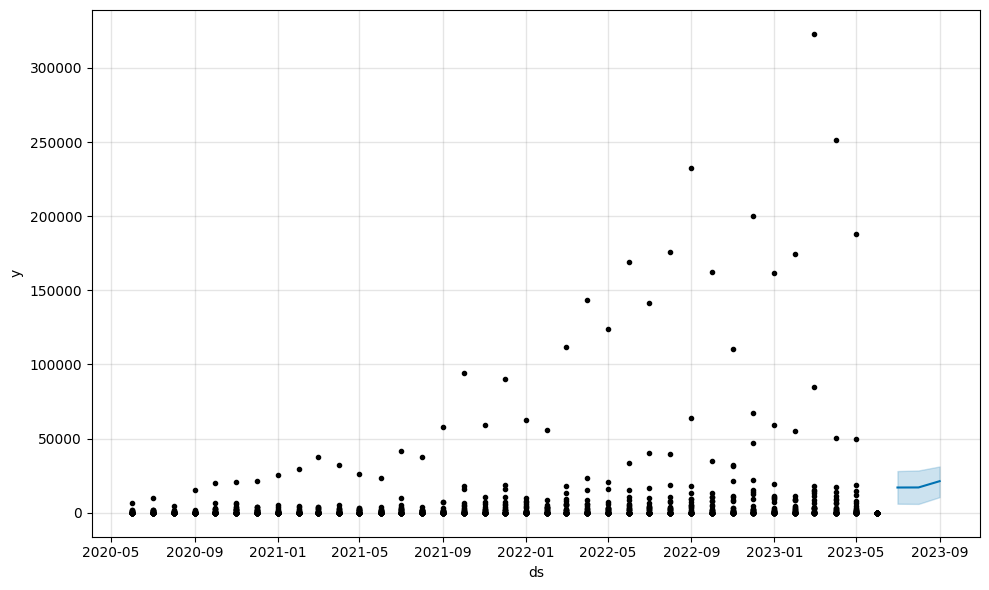

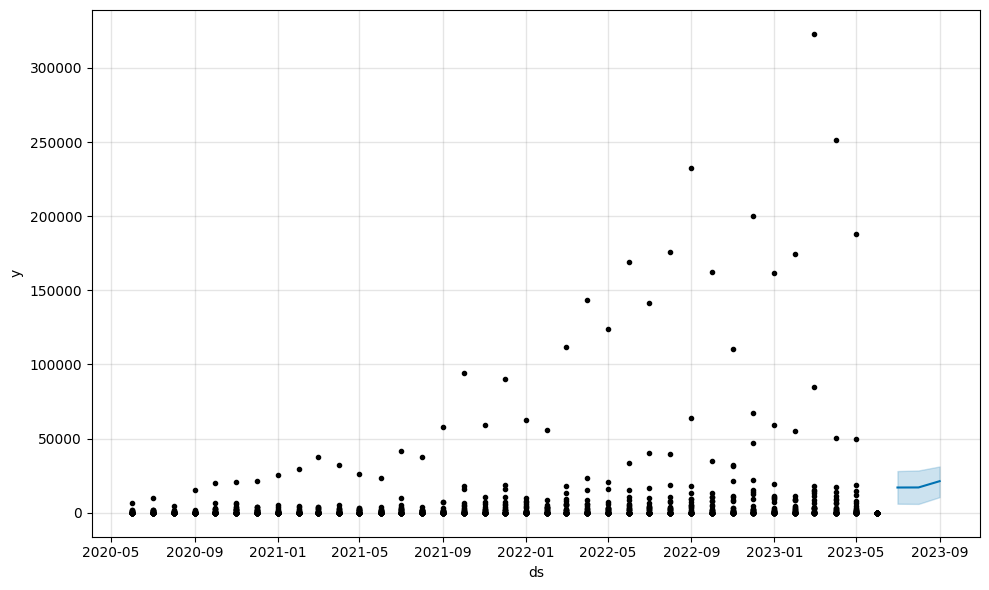

In [60]:
m.plot(forecast)